In [1]:
import os, time
import pandas as pd
import numpy as np

In [2]:
PH2DIR = "../artifacts/phase2_preprocessing"
PH4DIR = "../artifacts/phase4_linkage"
PH4_MED_PECOS_DIR = "../artifacts/phase4_linkage"
OUTPUTDIR = "../artifacts/phase5_entity_resolution"

In [3]:
opclean = pd.read_parquet(os.path.join(PH2DIR, "open_payments_clean.parquet"))
medclean = pd.read_parquet(os.path.join(PH2DIR, "medicare_clean.parquet"))
pecosclean = pd.read_parquet(os.path.join(PH2DIR, "pecos_clean.parquet"))

In [4]:
op_med_feature = pd.read_csv(os.path.join(PH4DIR, "feature_matrix.csv"))
medpecos_tier1 = pd.read_parquet(os.path.join(PH4_MED_PECOS_DIR, "med_pecos_tier1_npi.parquet"))
med_pecos_feat = pd.read_csv(os.path.join(PH4_MED_PECOS_DIR, "feature_matrix.csv"))

## 5.0 Diagnostic: Inspect opclean Schema

**MUST RUN FIRST** — prints every column name, dtypes, and a sample of
tier-1 NPI records so we can identify the correct NPI column for merging.

In [5]:
# ============================================================
# 5.0 DIAGNOSTIC — INSPECT OPCLEAN TO FIND NPI COLUMN
# ============================================================
print("=" * 60)
print("5.0 DIAGNOSTIC: OPCLEAN SCHEMA")
print("=" * 60)

print(f"\nopclean shape: {opclean.shape}")
print(f"\nAll columns ({len(opclean.columns)}):")
for i, c in enumerate(opclean.columns):
    print(f"  [{i:>3}] {c:<50s}  dtype={opclean[c].dtype}")

print(f"\nlinkage_tier distribution:")
print(opclean["linkage_tier"].value_counts().to_string())

# Show tier-1 sample
op_t1_sample = opclean[opclean["linkage_tier"] == "tier1_npi"].head(3)
print(f"\nTier-1 NPI sample (first 3 rows):")
print(op_t1_sample.to_string())

# Identify candidate NPI columns
npi_candidates = [c for c in opclean.columns if "npi" in c.lower()]
print(f"\nColumns containing 'npi': {npi_candidates}")

for nc in npi_candidates:
    print(f"\n  {nc}: dtype={opclean[nc].dtype}, "
          f"nunique={opclean[nc].nunique()}, "
          f"sample={opclean[nc].dropna().head(3).tolist()}")

5.0 DIAGNOSTIC: OPCLEAN SCHEMA

opclean shape: (969703, 22)

All columns (22):
  [  0] Covered_Recipient_NPI                               dtype=float64
  [  1] Covered_Recipient_Profile_ID                        dtype=float64
  [  2] Covered_Recipient_First_Name                        dtype=object
  [  3] Covered_Recipient_Last_Name                         dtype=object
  [  4] Recipient_Primary_Business_Street_Address_Line1     dtype=object
  [  5] Recipient_City                                      dtype=object
  [  6] Recipient_State                                     dtype=object
  [  7] Recipient_Zip5                                      dtype=object
  [  8] NPI_VALID                                           dtype=object
  [  9] LINKABLE                                            dtype=bool
  [ 10] linkage_tier                                        dtype=object
  [ 11] FIRST_NAME_SOUNDEX                                  dtype=object
  [ 12] LAST_NAME_SOUNDEX                    

## 5.1 Build Provider Entity Table
- Start from Medicare NPIs as the backbone entity set
- Assign integer `provider_id` to each unique NPI

In [6]:
print("=" * 60)
print("5.1 BUILD PROVIDER ENTITY TABLE")
print("=" * 60)

prov = medclean[
    ["Rndrng_NPI", "Rndrng_Prvdr_First_Name", "Rndrng_Prvdr_Last_Org_Name", "Rndrng_Prvdr_State_Abrvtn"]
].copy()

prov = prov.rename(columns={
    "Rndrng_NPI": "npi",
    "Rndrng_Prvdr_First_Name": "first_med",
    "Rndrng_Prvdr_Last_Org_Name": "last_med",
    "Rndrng_Prvdr_State_Abrvtn": "state_med",
})

prov["provider_id"] = np.arange(len(prov), dtype="int64")

print(f"Provider entities: {len(prov):,}")
print(f"prov['npi'] dtype: {prov['npi'].dtype}")
print(f"prov['npi'] sample: {prov['npi'].head(3).tolist()}")

5.1 BUILD PROVIDER ENTITY TABLE
Provider entities: 1,175,281
prov['npi'] dtype: int64
prov['npi'] sample: [1003000126, 1003000134, 1003000142]


## 5.1.1 Add Organization Providers to Backbone

In [7]:
print("=" * 60)
print("5.1.1 ADD ORGANIZATION PROVIDERS TO BACKBONE")
print("=" * 60)

prov["entity_type"] = "I"
n_indiv = len(prov)

med_org = medclean[medclean["Rndrng_Prvdr_Ent_Cd"] == "O"].copy()
med_org = med_org[med_org["NPI_VALID"]].copy()

prov_org = med_org[
    ["Rndrng_NPI", "Rndrng_Prvdr_Last_Org_Name", "Rndrng_Prvdr_State_Abrvtn"]
].copy()

prov_org = prov_org.rename(columns={
    "Rndrng_NPI": "npi",
    "Rndrng_Prvdr_Last_Org_Name": "last_med",
    "Rndrng_Prvdr_State_Abrvtn": "state_med",
})

prov_org["first_med"] = np.nan
prov_org["entity_type"] = "O"
prov_org["provider_id"] = np.arange(n_indiv, n_indiv + len(prov_org), dtype="int64")
prov_org = prov_org.drop_duplicates(subset="npi", keep="first")

prov = pd.concat([prov, prov_org], ignore_index=True)

print(f"Individual providers: {n_indiv:>10,}")
print(f"Organization providers: {len(prov_org):>10,}")
print(f"Total backbone entities: {len(prov):>10,}")
print(f"\nEntity type distribution:")
print(prov["entity_type"].value_counts().to_string())

5.1.1 ADD ORGANIZATION PROVIDERS TO BACKBONE
Individual providers:  1,175,281
Organization providers:     61,864
Total backbone entities:  1,237,145

Entity type distribution:
entity_type
I    1175281
O      61864


## 5.2 Attach Open Payments to Providers
- Filter feature matrix for `match` and `possible` tiers
- Map OP index → Medicare index → `provider_id`

In [8]:
print("=" * 60)
print("5.2 ATTACH OPEN PAYMENTS TO PROVIDERS")
print("=" * 60)

op_med_matches = op_med_feature[
    op_med_feature["match_tier"].isin(["match", "possible"])
].copy()

print(op_med_matches["match_tier"].value_counts())

op_idx_to_med_idx = op_med_matches[["index_op", "index_med"]].copy()
medclean_reset = medclean.reset_index().rename(columns={"index": "index_med"})

med_with_pid = medclean_reset.merge(
    prov[["npi", "provider_id"]],
    left_on="Rndrng_NPI",
    right_on="npi",
    how="left",
)

op_with_pid = (
    op_idx_to_med_idx
    .merge(
        med_with_pid[["index_med", "provider_id"]],
        left_on="index_med",
        right_on="index_med",
        how="left",
    )
)

total_pairs = len(op_with_pid)
pairs_with_pid = op_with_pid["provider_id"].notna().sum()
print(f"OP pairs with provider_id: {pairs_with_pid} of {total_pairs} "
      f"({pairs_with_pid / total_pairs:.1%})")

5.2 ATTACH OPEN PAYMENTS TO PROVIDERS
match_tier
match       482
possible     76
Name: count, dtype: int64
OP pairs with provider_id: 558 of 558 (100.0%)


## 5.3 Collapse to Unique OP → Provider ID

In [9]:
print("=" * 60)
print("5.3 COLLAPSE TO UNIQUE OP - PROVIDER_ID")
print("=" * 60)

op_with_pid = (
    op_med_matches[["index_op", "index_med"]]
    .merge(med_with_pid[["index_med", "provider_id"]], on="index_med", how="left")
)

assert op_with_pid["provider_id"].notna().all()

op_with_pid = op_with_pid.merge(
    op_med_matches[["index_op", "index_med", "match_tier"]],
    on=["index_op", "index_med"],
    how="left",
)

op_best = (
    op_with_pid
    .sort_values(["index_op", "match_tier"])
    .drop_duplicates(subset="index_op", keep="first")
)

print(f"Unique OP→provider links: {len(op_best):,}")
print(op_best[["index_op", "provider_id", "match_tier"]].head())

5.3 COLLAPSE TO UNIQUE OP - PROVIDER_ID
Unique OP→provider links: 438
     index_op  provider_id match_tier
348        15       717466      match
540        33       133903      match
546        36       355291      match
304        91       934974      match
232        99       245140      match


## 5.4 Attach Provider ID Back to OP Tier2

In [10]:
print("=" * 60)
print("5.4 ATTACH PROVIDER_ID BACK TO OP TIER2")
print("=" * 60)

optier2 = opclean[opclean["linkage_tier"] == "tier2_fuzzy"].copy()
optier2 = optier2.reset_index(drop=True)
optier2.index.name = "index_op"
optier2 = optier2.reset_index()

optier2_with_pid = optier2.merge(
    op_best[["index_op", "provider_id", "match_tier"]],
    on="index_op",
    how="left",
)

linked = optier2_with_pid["provider_id"].notna().sum()
total = len(optier2_with_pid)
print(f"Tier2 OP rows with provider_id: {linked:,} of {total:,} ({linked / total:.1%})")

optier2_with_pid.to_parquet(
    os.path.join(OUTPUTDIR, "open_payments_tier2_with_provider_id.parquet"),
    index=False,
)

5.4 ATTACH PROVIDER_ID BACK TO OP TIER2
Tier2 OP rows with provider_id: 438 of 4,683 (9.4%)


## 5.4.1 Integrate Tier-1 NPI Open Payments Records

**Gap #2 closed:** The original pipeline only linked OP→Medicare via tier-2 fuzzy matching.
This adds tier-1 NPI records (direct NPI match from Phase 2) via a robust NPI lookup.

**Fix v3:** Uses explicit column-detection with diagnostic output, and normalizes
both NPI columns to the same dtype before merging.

In [11]:
# ============================================================
# 5.4.1 INTEGRATE TIER-1 NPI OPEN PAYMENTS RECORDS  (FIXED v3)
# ============================================================
print("=" * 60)
print("5.4.1 INTEGRATE TIER-1 NPI OPEN PAYMENTS RECORDS")
print("=" * 60)
t0 = time.time()

# --- Step 1: Extract tier-1 NPI records ---
op_tier1 = opclean[opclean["linkage_tier"] == "tier1_npi"].copy()
op_tier1 = op_tier1.reset_index(drop=True)
print(f"Tier-1 NPI OP records: {len(op_tier1):,}")

if len(op_tier1) == 0:
    print("⚠️  WARNING: No tier-1 NPI records found in opclean!")
    print("   linkage_tier values:", opclean["linkage_tier"].unique().tolist())
    op_all_with_pid = optier2_with_pid[optier2_with_pid["provider_id"].notna()].copy()
    op_all_with_pid["match_tier"] = op_all_with_pid.get("match_tier", "tier2_fuzzy")
else:
    # --- Step 2: Find the NPI column ---
    # Try all known OP NPI column names
    npi_col = None
    candidates = [
        "Covered_Recipient_NPI",
        "covered_recipient_npi",
        "Physician_NPI",
        "physician_npi",
        "npi",
        "NPI",
        "Rndrng_NPI",
    ]
    for c in candidates:
        if c in op_tier1.columns:
            npi_col = c
            break

    # Fallback: any column with "npi" in name
    if npi_col is None:
        for c in op_tier1.columns:
            if "npi" in c.lower():
                npi_col = c
                break

    print(f"NPI column identified: {npi_col}")

    if npi_col is None:
        print("❌ FATAL: Cannot find any NPI column in opclean!")
        print(f"   Available columns: {op_tier1.columns.tolist()}")
        raise ValueError("No NPI column found in tier-1 OP records")

    print(f"  op_tier1['{npi_col}'] dtype : {op_tier1[npi_col].dtype}")
    print(f"  op_tier1['{npi_col}'] sample: {op_tier1[npi_col].dropna().head(3).tolist()}")
    print(f"  op_tier1['{npi_col}'] nulls : {op_tier1[npi_col].isna().sum()}")
    print(f"  prov['npi'] dtype : {prov['npi'].dtype}")
    print(f"  prov['npi'] sample: {prov['npi'].head(3).tolist()}")

    # --- Step 3: Normalize both sides to int64 for a clean merge ---
    #   NPI is a 10-digit integer. Cast both to int64 (drop NaN rows first).
    op_tier1 = op_tier1[op_tier1[npi_col].notna()].copy()

    # Coerce to numeric → int
    op_tier1["_merge_npi"] = pd.to_numeric(op_tier1[npi_col], errors="coerce").astype("Int64")
    prov["_merge_npi"] = pd.to_numeric(prov["npi"], errors="coerce").astype("Int64")

    pre_merge_count = len(op_tier1)
    op_tier1 = op_tier1[op_tier1["_merge_npi"].notna()].copy()
    print(f"  Records with valid numeric NPI: {len(op_tier1):,} / {pre_merge_count:,}")

    # Check overlap before merge
    op_npi_set = set(op_tier1["_merge_npi"].dropna().unique())
    prov_npi_set = set(prov["_merge_npi"].dropna().unique())
    overlap = op_npi_set & prov_npi_set
    print(f"  NPI overlap: {len(overlap):,} unique NPIs in BOTH op_tier1 and prov")
    print(f"    (op_tier1 unique NPIs: {len(op_npi_set):,}, prov unique NPIs: {len(prov_npi_set):,})")

    if len(overlap) == 0:
        print("⚠️  WARNING: ZERO NPI overlap! Check data pipeline.")
        print(f"  op_tier1 NPI sample: {sorted(list(op_npi_set))[:5]}")
        print(f"  prov NPI sample: {sorted(list(prov_npi_set))[:5]}")

    # --- Step 4: Merge ---
    op_tier1_with_pid = op_tier1.merge(
        prov[["_merge_npi", "provider_id"]].drop_duplicates(subset="_merge_npi"),
        on="_merge_npi",
        how="left",
    )

    tier1_linked = op_tier1_with_pid["provider_id"].notna().sum()
    print(f"\nTier-1 OP records with provider_id: {tier1_linked:,} / {len(op_tier1_with_pid):,} "
          f"({tier1_linked / len(op_tier1_with_pid):.1%})")

    # Clean up temp column from prov (don't pollute downstream)
    prov = prov.drop(columns=["_merge_npi"], errors="ignore")
    op_tier1_with_pid = op_tier1_with_pid.drop(columns=["_merge_npi"], errors="ignore")

    # --- Step 5: Tag match tier ---
    op_tier1_with_pid["match_tier"] = "tier1_npi"

    # --- Step 6: Combine tier-1 + tier-2 ---
    payment_cols_needed = ["payment_count", "total_payment_amount", "max_payment",
                           "min_payment_date", "max_payment_date", "unique_manufacturers"]
    tier2_cols = set(optier2_with_pid.columns)
    tier1_cols = set(op_tier1_with_pid.columns)
    common_payment_cols = [c for c in payment_cols_needed if c in tier1_cols and c in tier2_cols]
    print(f"Common payment columns: {common_payment_cols}")

    op_tier1_linked = op_tier1_with_pid[op_tier1_with_pid["provider_id"].notna()].copy()
    op_tier2_linked = optier2_with_pid[optier2_with_pid["provider_id"].notna()].copy()

    if "match_tier" not in op_tier2_linked.columns:
        op_tier2_linked["match_tier"] = "tier2_fuzzy"

    select_cols = ["provider_id", "match_tier"] + common_payment_cols
    op_all_with_pid = pd.concat([
        op_tier2_linked[[c for c in select_cols if c in op_tier2_linked.columns]],
        op_tier1_linked[[c for c in select_cols if c in op_tier1_linked.columns]],
    ], ignore_index=True)

    unique_providers_tier1 = op_tier1_linked["provider_id"].nunique()
    unique_providers_tier2 = op_tier2_linked["provider_id"].nunique()
    unique_providers_all = op_all_with_pid["provider_id"].nunique()

    print(f"\nUnique providers with OP data:")
    print(f"  Tier-2 fuzzy only:  {unique_providers_tier2:,}")
    print(f"  Tier-1 NPI only:    {unique_providers_tier1:,}")
    print(f"  Combined (deduped): {unique_providers_all:,}")

print(f"\nop_all_with_pid rows: {len(op_all_with_pid):,}")
print(f"Elapsed: {time.time() - t0:.1f}s")

5.4.1 INTEGRATE TIER-1 NPI OPEN PAYMENTS RECORDS
Tier-1 NPI OP records: 933,615
NPI column identified: Covered_Recipient_NPI
  op_tier1['Covered_Recipient_NPI'] dtype : float64
  op_tier1['Covered_Recipient_NPI'] sample: [1952716680.0, 1881880862.0, 1144497728.0]
  op_tier1['Covered_Recipient_NPI'] nulls : 0
  prov['npi'] dtype : int64
  prov['npi'] sample: [1003000126, 1003000134, 1003000142]
  Records with valid numeric NPI: 933,615 / 933,615
  NPI overlap: 542,329 unique NPIs in BOTH op_tier1 and prov
    (op_tier1 unique NPIs: 933,615, prov unique NPIs: 1,175,281)

Tier-1 OP records with provider_id: 542,329 / 933,615 (58.1%)
Common payment columns: ['payment_count', 'total_payment_amount', 'max_payment', 'min_payment_date', 'max_payment_date', 'unique_manufacturers']

Unique providers with OP data:
  Tier-2 fuzzy only:  436
  Tier-1 NPI only:    542,329
  Combined (deduped): 542,442

op_all_with_pid rows: 542,767
Elapsed: 3.0s


## 5.5 Aggregate Payment Statistics (Tier-1 + Tier-2 Combined)

In [12]:
print("=" * 60)
print("5.5 AGGREGATE PAYMENT STATISTICS (TIER-1 + TIER-2 COMBINED)")
print("=" * 60)

provpay = (
    op_all_with_pid[op_all_with_pid["provider_id"].notna()]
    .groupby("provider_id")
    .agg(
        n_payments=("payment_count", "sum"),
        sum_payment=("total_payment_amount", "sum"),
        avg_payment=("total_payment_amount", "mean"),
        max_payment=("max_payment", "max"),
        first_payment_date=("min_payment_date", "min"),
        last_payment_date=("max_payment_date", "max"),
        unique_manufacturers=("unique_manufacturers", "max"),
    )
    .reset_index()
)

print(f"Providers with payment data: {len(provpay):,}")
print(provpay.head())

prov.to_parquet(os.path.join(OUTPUTDIR, "provider_entities.parquet"), index=False)
provpay.to_parquet(os.path.join(OUTPUTDIR, "provider_payments.parquet"), index=False)

5.5 AGGREGATE PAYMENT STATISTICS (TIER-1 + TIER-2 COMBINED)
Providers with payment data: 542,442
   provider_id  n_payments  sum_payment  avg_payment  max_payment  \
0          0.0           1        20.78        20.78        20.78   
1          2.0          60      3069.11      3069.11       821.73   
2          3.0          18       368.54       368.54        45.15   
3          4.0           2      1950.00      1950.00      1170.00   
4          6.0         101      1832.66      1832.66       152.92   

  first_payment_date last_payment_date  unique_manufacturers  
0         2023-02-24        2023-02-24                     1  
1         2023-01-10        2023-12-07                     9  
2         2023-01-04        2023-12-12                    10  
3         2023-08-03        2023-12-20                     1  
4         2023-01-04        2023-12-13                    16  


## 5.6 Med→PECOS Linkage

In [13]:
print("=" * 60)
print("5.6 MED→PECOS LINKAGE")
print("=" * 60)

print(f"medpecos_tier1 columns: {medpecos_tier1.columns.tolist()}")
print(f"medpecos_tier1 rows: {len(medpecos_tier1):,}")
print(f"  Rndrng_NPI dtype: {medpecos_tier1['Rndrng_NPI'].dtype}")
print(f"  prov['npi'] dtype: {prov['npi'].dtype}")

# Normalize both to Int64 for safe merge
medpecos_tier1["_merge_npi"] = pd.to_numeric(medpecos_tier1["Rndrng_NPI"], errors="coerce").astype("Int64")
prov["_merge_npi"] = pd.to_numeric(prov["npi"], errors="coerce").astype("Int64")

medpecos_tier1 = medpecos_tier1.merge(
    prov[["_merge_npi", "provider_id"]].drop_duplicates(subset="_merge_npi"),
    on="_merge_npi",
    how="left",
)

# Clean up
medpecos_tier1 = medpecos_tier1.drop(columns=["_merge_npi"], errors="ignore")
prov = prov.drop(columns=["_merge_npi"], errors="ignore")

if "provider_id_y" in medpecos_tier1.columns:
    medpecos_tier1 = medpecos_tier1.rename(columns={"provider_id_y": "provider_id"})
    medpecos_tier1 = medpecos_tier1.drop(columns=["provider_id_x"], errors="ignore")

mp_tier1_with_pid = medpecos_tier1[medpecos_tier1["provider_id"].notna()].copy()

print(f"Med→PECOS links with provider_id: {len(mp_tier1_with_pid):,}")
print(f"Columns: {mp_tier1_with_pid.columns.tolist()}")
mp_tier1_with_pid.head()

5.6 MED→PECOS LINKAGE
medpecos_tier1 columns: ['Rndrng_NPI', 'Rndrng_Prvdr_First_Name', 'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_State_Abrvtn', 'ENRLMT_ID', 'ENRLMT_YEAR', 'FIRST_NAME', 'LAST_NAME', 'STATE_CD']
medpecos_tier1 rows: 1,084,185
  Rndrng_NPI dtype: int64
  prov['npi'] dtype: int64
Med→PECOS links with provider_id: 1,084,185
Columns: ['Rndrng_NPI', 'Rndrng_Prvdr_First_Name', 'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_State_Abrvtn', 'ENRLMT_ID', 'ENRLMT_YEAR', 'FIRST_NAME', 'LAST_NAME', 'STATE_CD', 'provider_id']


,Rndrng_NPI,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_State_Abrvtn,ENRLMT_ID,ENRLMT_YEAR,FIRST_NAME,LAST_NAME,STATE_CD,provider_id
0,1003000126,ARDALAN,ENKESHAFI,MD,I20231208000285,2023,ARDALAN,ENKESHAFI,PA,0
1,1003000134,THOMAS,CIBULL,IL,I20080707000385,2008,THOMAS,CIBULL,IL,1
2,1003000142,RASHID,KHALIL,OH,I20120405000290,2012,RASHID,KHALIL,MI,2
3,1003000423,JENNIFER,VELOTTA,OH,I20110715000515,2011,JENNIFER,VELOTTA,OH,3
4,1003000480,KEVIN,ROTHCHILD,CO,I20071113000017,2007,KEVIN,ROTHCHILD,CO,4


## 5.6.1 Org-Level Med→PECOS Linkage

In [15]:
print("=" * 60)
print("5.6.1 ORG-LEVEL MED→PECOS LINKAGE")
print("=" * 60)

med_pecos_org_tier1 = pd.read_parquet(
    os.path.join(PH4_MED_PECOS_DIR, "medpecos_org_tier1_npi.parquet")
)
print(f"Org PECOS links loaded: {len(med_pecos_org_tier1):>10,}")

# Normalize to Int64
med_pecos_org_tier1["_merge_npi"] = pd.to_numeric(med_pecos_org_tier1["Rndrng_NPI"], errors="coerce").astype("Int64")
prov["_merge_npi"] = pd.to_numeric(prov["npi"], errors="coerce").astype("Int64")

med_pecos_org_tier1 = med_pecos_org_tier1.merge(
    prov[["_merge_npi", "provider_id"]].drop_duplicates(subset="_merge_npi"),
    on="_merge_npi",
    how="left",
)

med_pecos_org_tier1 = med_pecos_org_tier1.drop(columns=["_merge_npi"], errors="ignore")
prov = prov.drop(columns=["_merge_npi"], errors="ignore")

if "provider_id_y" in med_pecos_org_tier1.columns:
    med_pecos_org_tier1 = med_pecos_org_tier1.rename(columns={"provider_id_y": "provider_id"})
    med_pecos_org_tier1 = med_pecos_org_tier1.drop(columns=["provider_id_x"], errors="ignore")

mp_org_tier1_with_pid = med_pecos_org_tier1[med_pecos_org_tier1["provider_id"].notna()].copy()

print(f"Org PECOS links with provider_id: {len(mp_org_tier1_with_pid):>10,}")
print(f"Org PECOS links missing provider_id: "
      f"{len(med_pecos_org_tier1) - len(mp_org_tier1_with_pid):>10,}")

5.6.1 ORG-LEVEL MED→PECOS LINKAGE
Org PECOS links loaded:     54,278
Org PECOS links with provider_id:     54,278
Org PECOS links missing provider_id:          0


## 5.7 Complete Med→PECOS Integration

In [16]:
print("=" * 60)
print("5.7 COMPLETE MED→PECOS INTEGRATION (INDIVIDUALS + ORGS)")
print("=" * 60)
t0 = time.time()

pecosagg_indiv = (
    mp_tier1_with_pid
    .sort_values("ENRLMT_YEAR", ascending=False)
    .groupby("provider_id")
    .agg(
        pecos_enrollment_id=("ENRLMT_ID", "first"),
        pecos_enrollment_year=("ENRLMT_YEAR", "max"),
        pecos_first_name=("FIRST_NAME", "first"),
        pecos_last_name=("LAST_NAME", "first"),
        pecos_state=("STATE_CD", "first"),
    )
    .reset_index()
)
print(f"Individual providers with PECOS: {len(pecosagg_indiv):>10,}")

ORGNAME_COL = "ORGNAME" if "ORGNAME" in mp_org_tier1_with_pid.columns else "ORGNAME"
ORG_LASTNAME_COL = (
    "Rndrng_Prvdr_Last_Org_Name"
    if "Rndrng_Prvdr_Last_Org_Name" in mp_org_tier1_with_pid.columns
    else ORGNAME_COL
)

pecosagg_org = (
    mp_org_tier1_with_pid
    .sort_values("ENRLMT_YEAR", ascending=False)
    .groupby("provider_id")
    .agg(
        pecos_enrollment_id=("ENRLMT_ID", "first"),
        pecos_enrollment_year=("ENRLMT_YEAR", "max"),
        pecos_last_name=(ORG_LASTNAME_COL, "first") if ORG_LASTNAME_COL in mp_org_tier1_with_pid.columns
            else ("ENRLMT_ID", lambda x: np.nan),
        pecos_state=("STATE_CD", "first") if "STATE_CD" in mp_org_tier1_with_pid.columns
            else ("ENRLMT_ID", lambda x: np.nan),
    )
    .reset_index()
)
pecosagg_org["pecos_first_name"] = np.nan
print(f"Org providers with PECOS: {len(pecosagg_org):>10,}")

pecos_agg = pd.concat([pecosagg_indiv, pecosagg_org], ignore_index=True)
print(f"Total providers with PECOS data: {len(pecos_agg):>10,}")

prov_enhanced = prov.merge(pecos_agg, on="provider_id", how="left")
prov_enhanced = prov_enhanced.merge(provpay, on="provider_id", how="left")

has_pecos = prov_enhanced["pecos_enrollment_id"].notna().sum()
has_payments = prov_enhanced["n_payments"].notna().sum()
total_prov = len(prov_enhanced)

print(f"\nProviders with PECOS enrollment: {has_pecos:>10,} / {total_prov:>10,} ({has_pecos / total_prov:.1%})")
print(f"Providers with OP payment data:  {has_payments:>10,} / {total_prov:>10,} ({has_payments / total_prov:.1%})")
print(f"\nEntity type breakdown:")
print(prov_enhanced.groupby("entity_type")["pecos_enrollment_id"].apply(
    lambda s: f"{s.notna().sum():,} / {len(s):,} ({s.notna().mean():.1%})"
).to_string())
print(f"\nprov_enhanced shape: {prov_enhanced.shape}")
print(f"Elapsed: {time.time() - t0:.1f}s")

5.7 COMPLETE MED→PECOS INTEGRATION (INDIVIDUALS + ORGS)
Individual providers with PECOS:  1,084,185
Org providers with PECOS:     54,278
Total providers with PECOS data:  1,138,463

Providers with PECOS enrollment:  1,138,463 /  1,237,145 (92.0%)
Providers with OP payment data:     542,442 /  1,237,145 (43.8%)

Entity type breakdown:
entity_type
I    1,138,463 / 1,175,281 (96.9%)
O                0 / 61,864 (0.0%)

prov_enhanced shape: (1237145, 18)
Elapsed: 2.7s


## 5.8 Build Unified 3-Way Entity Table

In [17]:
print("=" * 60)
print("5.8 BUILD UNIFIED 3-WAY ENTITY TABLE")
print("=" * 60)
t0 = time.time()

unified = prov_enhanced.copy()

unified["first_name_reconciled"] = unified["first_med"].fillna(unified["pecos_first_name"])
unified["last_name_reconciled"] = unified["last_med"].fillna(unified["pecos_last_name"])
unified["state_reconciled"] = unified["state_med"].fillna(unified["pecos_state"])

unified["has_op_payments"] = unified["n_payments"].notna()
unified["has_pecos_enrollment"] = unified["pecos_enrollment_id"].notna()
unified["linkage_coverage"] = (
    unified["has_op_payments"].astype(int) + unified["has_pecos_enrollment"].astype(int)
)

def label_sources(row):
    prefix = "Medicare+Org" if row.get("entity_type") == "O" else "Medicare"
    sources = [prefix]
    if row["has_op_payments"]:
        sources.append("OP")
    if row["has_pecos_enrollment"]:
        sources.append("PECOS")
    return "+".join(sources)

unified["data_sources"] = unified.apply(label_sources, axis=1)

print("--- Linkage Coverage Distribution ---")
print(unified["linkage_coverage"].value_counts().sort_index().to_string())
print("\n--- Data Source Combinations ---")
print(unified["data_sources"].value_counts().to_string())
print(f"\nTotal unified providers: {len(unified):,}")

unified.to_parquet(os.path.join(OUTPUTDIR, "unified_provider_entities.parquet"), index=False)
print(f"\n✅ Exported unified_provider_entities.parquet: {len(unified):,} rows")
print(f"Elapsed: {time.time() - t0:.1f}s")
unified.head(10)

5.8 BUILD UNIFIED 3-WAY ENTITY TABLE
--- Linkage Coverage Distribution ---
linkage_coverage
0     89506
1    614373
2    533266

--- Data Source Combinations ---
data_sources
Medicare+PECOS       605197
Medicare+OP+PECOS    533266
Medicare+Org          61864
Medicare              27642
Medicare+OP            9176

Total unified providers: 1,237,145

✅ Exported unified_provider_entities.parquet: 1,237,145 rows
Elapsed: 12.0s


,npi,first_med,last_med,state_med,provider_id,entity_type,pecos_enrollment_id,pecos_enrollment_year,pecos_first_name,pecos_last_name,...,first_payment_date,last_payment_date,unique_manufacturers,first_name_reconciled,last_name_reconciled,state_reconciled,has_op_payments,has_pecos_enrollment,linkage_coverage,data_sources
0,1003000126,ARDALAN,ENKESHAFI,MD,0,I,I20231208000285,2023,ARDALAN,ENKESHAFI,...,2023-02-24,2023-02-24,1.0,ARDALAN,ENKESHAFI,MD,True,True,2,Medicare+OP+PECOS
1,1003000134,THOMAS,CIBULL,IL,1,I,I20080707000385,2008,THOMAS,CIBULL,...,NaT,NaT,NaN,THOMAS,CIBULL,IL,False,True,1,Medicare+PECOS
2,1003000142,RASHID,KHALIL,OH,2,I,I20120405000290,2012,RASHID,KHALIL,...,2023-01-10,2023-12-07,9.0,RASHID,KHALIL,OH,True,True,2,Medicare+OP+PECOS
3,1003000423,JENNIFER,VELOTTA,OH,3,I,I20110715000515,2011,JENNIFER,VELOTTA,...,2023-01-04,2023-12-12,10.0,JENNIFER,VELOTTA,OH,True,True,2,Medicare+OP+PECOS
4,1003000480,KEVIN,ROTHCHILD,CO,4,I,I20071113000017,2007,KEVIN,ROTHCHILD,...,2023-08-03,2023-12-20,1.0,KEVIN,ROTHCHILD,CO,True,True,2,Medicare+OP+PECOS
5,1003000530,AMANDA,SEMONCHE,PA,5,I,I20090731000112,2009,AMANDA,SEMONCHE,...,NaT,NaT,NaN,AMANDA,SEMONCHE,PA,False,True,1,Medicare+PECOS
6,1003000597,DAE,KIM,OK,6,I,I20150912000130,2015,DAE,KIM,...,2023-01-04,2023-12-13,16.0,DAE,KIM,OK,True,True,2,Medicare+OP+PECOS
7,1003000639,PEYMAN,BENHARASH,CA,7,I,I20101101001099,2010,PEYMAN,BENHARASH,...,2023-01-30,2023-12-19,7.0,PEYMAN,BENHARASH,CA,True,True,2,Medicare+OP+PECOS
8,1003000704,ZACHARY,GATTON,OH,8,I,I20110815000351,2011,ZACHARY,GATTON,...,NaT,NaT,NaN,ZACHARY,GATTON,OH,False,True,1,Medicare+PECOS
9,1003000720,OTNIEL,HERNANDEZ,FL,9,I,I20190918000212,2019,OTNIEL,HERNANDEZ,...,NaT,NaT,NaN,OTNIEL,HERNANDEZ,FL,False,True,1,Medicare+PECOS


## 5.9 Transitive Closure: OP → Med → PECOS Chains

In [18]:
print("=" * 60)
print("5.9 TRANSITIVE CLOSURE: OP → MED → PECOS CHAINS")
print("=" * 60)
t0 = time.time()

op_linked = optier2_with_pid[optier2_with_pid["provider_id"].notna()].copy()

pecos_link = (
    mp_tier1_with_pid[["provider_id", "ENRLMT_ID", "ENRLMT_YEAR"]]
    .sort_values("ENRLMT_YEAR", ascending=False)
    .drop_duplicates(subset="provider_id", keep="first")
)

op_pecos_chains = op_linked[["index_op", "provider_id", "match_tier"]].merge(
    pecos_link, on="provider_id", how="left",
)

op_pecos_chains["linkage_path"] = op_pecos_chains.apply(
    lambda r: (
        f"Tier2_Fuzzy({r['match_tier']}) → NPI → PECOS"
        if pd.notna(r["ENRLMT_ID"])
        else f"Tier2_Fuzzy({r['match_tier']}) → NPI → no PECOS"
    ),
    axis=1,
)

total_op_tier2 = len(optier2_with_pid)
op_with_med = len(op_linked)
op_with_full_chain = op_pecos_chains["ENRLMT_ID"].notna().sum()

print(f"\nTotal OP tier2 records: {total_op_tier2:,}")
print(f"OP records with provider_id (Med link): {op_with_med:,} ({op_with_med / total_op_tier2:.1%})")
print(f"OP records with full OP→Med→PECOS chain: {op_with_full_chain:,} ({op_with_full_chain / total_op_tier2:.1%})")

op_pecos_chains.to_parquet(
    os.path.join(OUTPUTDIR, "op_med_pecos_transitive_links.parquet"), index=False,
)
print(f"\n✅ Exported op_med_pecos_transitive_links.parquet: {len(op_pecos_chains):,} rows")
print(f"Elapsed: {time.time() - t0:.1f}s")

5.9 TRANSITIVE CLOSURE: OP → MED → PECOS CHAINS

Total OP tier2 records: 4,683
OP records with provider_id (Med link): 438 (9.4%)
OP records with full OP→Med→PECOS chain: 365 (7.8%)

✅ Exported op_med_pecos_transitive_links.parquet: 438 rows
Elapsed: 0.5s


## 5.10 Conflict Detection & Data Quality

In [19]:
print("=" * 60)
print("5.10 CONFLICT DETECTION & DATA QUALITY")
print("=" * 60)
t0 = time.time()

# Part A: Multi-Match
print("\n--- Part A: Multi-Match Conflicts ---")
multi_match = op_with_pid.groupby("index_op").filter(lambda g: len(g) > 1)
n_conflicted_op = multi_match["index_op"].nunique()
print(f"OP records matching multiple Medicare providers: {n_conflicted_op:,}")
if n_conflicted_op > 0:
    top5 = multi_match.sort_values(["index_op", "match_tier"]).groupby("index_op").head(5).head(10)
    print(top5[["index_op", "index_med", "provider_id", "match_tier"]].to_string(index=False))
assert n_conflicted_op < 100

# Part B: Name Mismatch
print("\n--- Part B: Name Mismatches (Medicare vs PECOS) ---")
has_both = prov_enhanced[
    prov_enhanced["pecos_first_name"].notna() & prov_enhanced["first_med"].notna()
].copy()
has_both["first_mismatch"] = has_both["first_med"].str.upper() != has_both["pecos_first_name"].str.upper()
has_both["last_mismatch"] = has_both["last_med"].str.upper() != has_both["pecos_last_name"].str.upper()
has_both["any_mismatch"] = has_both["first_mismatch"] | has_both["last_mismatch"]
n_mismatch = has_both["any_mismatch"].sum()
n_checked = len(has_both)
mismatch_rate = n_mismatch / n_checked if n_checked > 0 else 0
print(f"Providers checked: {n_checked:,}")
print(f"Name mismatches: {n_mismatch:,} ({mismatch_rate:.2%})")

# Part C: Export
quality_summary = pd.DataFrame([
    {"conflict_type": "multi_match", "count": n_conflicted_op,
     "denominator": len(op_with_pid["index_op"].unique()),
     "pct_affected": n_conflicted_op / max(1, len(op_with_pid["index_op"].unique())) * 100},
    {"conflict_type": "name_mismatch", "count": n_mismatch,
     "denominator": n_checked, "pct_affected": mismatch_rate * 100},
])
quality_summary.to_csv(os.path.join(OUTPUTDIR, "data_quality_conflicts.csv"), index=False)
print(f"\n✅ Exported data_quality_conflicts.csv")
print(f"Elapsed: {time.time() - t0:.1f}s")

5.10 CONFLICT DETECTION & DATA QUALITY

--- Part A: Multi-Match Conflicts ---
OP records matching multiple Medicare providers: 82
 index_op  index_med  provider_id match_tier
      205     924739       924739      match
      205      72109        72109      match
      205    1072058      1072058      match
      232     565317       565317      match
      232     740667       740667      match
      232     767437       767437      match
      252     751882       751882      match
      252     738741       738741      match
      252     713308       713308   possible
      257     884862       884862      match

--- Part B: Name Mismatches (Medicare vs PECOS) ---
Providers checked: 1,084,185
Name mismatches: 28,787 (2.66%)

✅ Exported data_quality_conflicts.csv
Elapsed: 1.5s


## 5.11 Coverage Venn Diagram Visualization

**Note:** OP set now uses `op_all_with_pid` (tier-1 NPI + tier-2 fuzzy combined).

5.11 COVERAGE VENN DIAGRAM VISUALIZATION
Open Payments linked providers: 542,442
Medicare providers (backbone):  1,237,145
PECOS enrolled providers:       1,138,463
  pecos_npis_indiv size: 1,084,185
  pecos_npis_org size:   54,278
  pecos_npis union size: 1,138,463
  mp_org_tier1_with_pid rows: 54,278
  mp_org_tier1_with_pid provider_id nulls: 0

--- Intersection Counts ---
OP only:          0
Medicare only:    89,506
PECOS only:       0
OP ∩ Med:         9,176
Med ∩ PECOS:      605,197
OP ∩ PECOS:       0
OP ∩ Med ∩ PECOS: 533,266


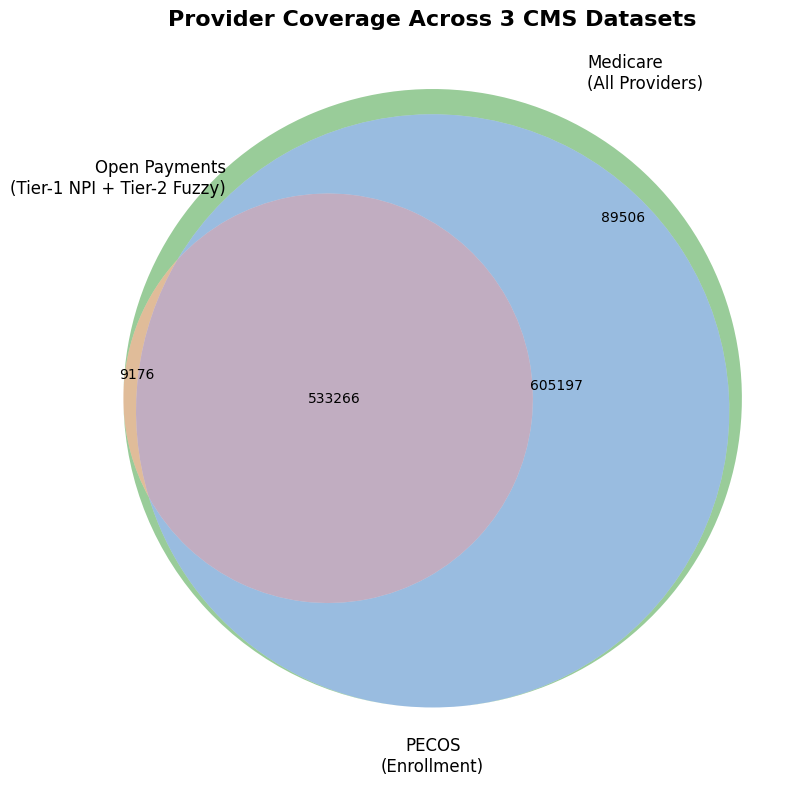


✅ Saved ../artifacts/phase5_entity_resolution\provider_coverage_venn.png
✅ Saved ../artifacts/phase5_entity_resolution\provider_coverage_summary.csv
Elapsed: 3.5s


,region,count
0,OP_only,0
1,Medicare_only,89506
2,PECOS_only,0
3,OP_Med,9176
4,Med_PECOS,605197
5,OP_PECOS,0
6,All_three,533266


In [22]:
print("=" * 60)
print("5.11 COVERAGE VENN DIAGRAM VISUALIZATION")
print("=" * 60)
t0 = time.time()

import matplotlib.pyplot as plt
try:
    from matplotlib_venn import venn3
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "matplotlib-venn"])
    from matplotlib_venn import venn3

# OP: from op_all_with_pid (tier-1 + tier-2)
op_npis = set(
    op_all_with_pid.loc[op_all_with_pid["provider_id"].notna(), "provider_id"].unique()
)

# Medicare: full backbone
med_npis = set(prov["provider_id"].unique())

# PECOS
pecos_npis_indiv = set(mp_tier1_with_pid.loc[mp_tier1_with_pid["provider_id"].notna(), "provider_id"].unique())
pecos_npis_org = set(mp_org_tier1_with_pid["provider_id"].unique())
pecos_npis = pecos_npis_indiv | pecos_npis_org

print(f"Open Payments linked providers: {len(op_npis):,}")
print(f"Medicare providers (backbone):  {len(med_npis):,}")
print(f"PECOS enrolled providers:       {len(pecos_npis):,}")

op_only = op_npis - med_npis - pecos_npis
med_only = med_npis - op_npis - pecos_npis
pecos_only = pecos_npis - med_npis - op_npis
op_med = (op_npis & med_npis) - pecos_npis
med_pecos = (med_npis & pecos_npis) - op_npis
op_pecos = (op_npis & pecos_npis) - med_npis
all_three = op_npis & med_npis & pecos_npis

print(f"  pecos_npis_indiv size: {len(pecos_npis_indiv):,}")
print(f"  pecos_npis_org size:   {len(pecos_npis_org):,}")
print(f"  pecos_npis union size: {len(pecos_npis):,}")
print(f"  mp_org_tier1_with_pid rows: {len(mp_org_tier1_with_pid):,}")
print(f"  mp_org_tier1_with_pid provider_id nulls: {mp_org_tier1_with_pid['provider_id'].isna().sum():,}")


print(f"\n--- Intersection Counts ---")
print(f"OP only:          {len(op_only):,}")
print(f"Medicare only:    {len(med_only):,}")
print(f"PECOS only:       {len(pecos_only):,}")
print(f"OP ∩ Med:         {len(op_med):,}")
print(f"Med ∩ PECOS:      {len(med_pecos):,}")
print(f"OP ∩ PECOS:       {len(op_pecos):,}")
print(f"OP ∩ Med ∩ PECOS: {len(all_three):,}")

fig, ax = plt.subplots(figsize=(10, 8))
v = venn3(
    [op_npis, med_npis, pecos_npis],
    set_labels=(
        "Open Payments\n(Tier-1 NPI + Tier-2 Fuzzy)",
        "Medicare\n(All Providers)",
        "PECOS\n(Enrollment)",
    ),
    ax=ax,
)
ax.set_title("Provider Coverage Across 3 CMS Datasets", fontsize=16, fontweight="bold")
plt.tight_layout()

venn_path = os.path.join(OUTPUTDIR, "provider_coverage_venn.png")
fig.savefig(venn_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"\n✅ Saved {venn_path}")

coverage_summary = pd.DataFrame([
    {"region": "OP_only", "count": len(op_only)},
    {"region": "Medicare_only", "count": len(med_only)},
    {"region": "PECOS_only", "count": len(pecos_only)},
    {"region": "OP_Med", "count": len(op_med)},
    {"region": "Med_PECOS", "count": len(med_pecos)},
    {"region": "OP_PECOS", "count": len(op_pecos)},
    {"region": "All_three", "count": len(all_three)},
])
coverage_csv_path = os.path.join(OUTPUTDIR, "provider_coverage_summary.csv")
coverage_summary.to_csv(coverage_csv_path, index=False)
print(f"✅ Saved {coverage_csv_path}")
print(f"Elapsed: {time.time() - t0:.1f}s")
coverage_summary

## 5.12 Phase 5 Summary Statistics & Export

In [21]:
print("=" * 60)
print("5.12 PHASE 5 SUMMARY STATISTICS")
print("=" * 60)

summary_stats = pd.DataFrame([
    {"metric": "total_providers_medicare_backbone", "value": len(prov)},
    {"metric": "providers_with_pecos_enrollment", "value": int(unified["has_pecos_enrollment"].sum())},
    {"metric": "providers_with_op_payments", "value": int(unified["has_op_payments"].sum())},
    {"metric": "providers_linkage_coverage_0", "value": int((unified["linkage_coverage"] == 0).sum())},
    {"metric": "providers_linkage_coverage_1", "value": int((unified["linkage_coverage"] == 1).sum())},
    {"metric": "providers_linkage_coverage_2", "value": int((unified["linkage_coverage"] == 2).sum())},
    {"metric": "op_tier2_total_records", "value": len(optier2_with_pid)},
    {"metric": "op_tier2_with_med_link", "value": int(optier2_with_pid["provider_id"].notna().sum())},
    {"metric": "op_all_with_pid_total", "value": len(op_all_with_pid)},
    {"metric": "op_all_unique_providers", "value": int(op_all_with_pid["provider_id"].nunique())},
    {"metric": "op_med_pecos_full_chains", "value": int(op_pecos_chains["ENRLMT_ID"].notna().sum())},
    {"metric": "multi_match_conflicts", "value": n_conflicted_op},
    {"metric": "name_mismatches", "value": n_mismatch},
])

summary_path = os.path.join(OUTPUTDIR, "phase5_summary_stats.csv")
summary_stats.to_csv(summary_path, index=False)
print(summary_stats.to_string(index=False))

print("\n" + "=" * 60)
print("PHASE 5 DELIVERABLES")
print("=" * 60)
deliverables = [
    "provider_entities.parquet", "provider_payments.parquet",
    "open_payments_tier2_with_provider_id.parquet",
    "unified_provider_entities.parquet", "op_med_pecos_transitive_links.parquet",
    "data_quality_conflicts.csv", "provider_coverage_venn.png",
    "provider_coverage_summary.csv", "phase5_summary_stats.csv",
]
for f in deliverables:
    path = os.path.join(OUTPUTDIR, f)
    exists = os.path.exists(path)
    status = "✅" if exists else "❌"
    size = f"{os.path.getsize(path) / 1024:.0f} KB" if exists else "MISSING"
    print(f"  {status} {f:<50s} {size}")

print("\n🎉 Phase 5 Entity Resolution COMPLETE")
print("=" * 60)

5.12 PHASE 5 SUMMARY STATISTICS
                           metric   value
total_providers_medicare_backbone 1237145
  providers_with_pecos_enrollment 1138463
       providers_with_op_payments  542442
     providers_linkage_coverage_0   89506
     providers_linkage_coverage_1  614373
     providers_linkage_coverage_2  533266
           op_tier2_total_records    4683
           op_tier2_with_med_link     438
            op_all_with_pid_total  542767
          op_all_unique_providers  542442
         op_med_pecos_full_chains     365
            multi_match_conflicts      82
                  name_mismatches   28787

PHASE 5 DELIVERABLES
  ✅ provider_entities.parquet                          23761 KB
  ✅ provider_payments.parquet                          11086 KB
  ✅ open_payments_tier2_with_provider_id.parquet       369 KB
  ✅ unified_provider_entities.parquet                  69451 KB
  ✅ op_med_pecos_transitive_links.parquet              14 KB
  ✅ data_quality_conflicts.csv             